In [1]:
import json
import os
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageDraw
import numpy as np
from torchvision import transforms

In [2]:

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and JSON files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.img_files[idx])
        json_file = img_name.replace('.png', '.json')

        with open(json_file) as f:
            annotations = json.load(f)['annotations']

        # Load image
        image = Image.open(img_name).convert('RGB')

        # Create an empty mask
        mask = Image.new('L', image.size, 0)

        # Create a draw object
        draw = ImageDraw.Draw(mask)

        # Draw polygons or bounding boxes on the mask
        for annotation in annotations:
            if 'polygon' in annotation:  # Check if polygon data exists
                polygon = annotation['polygon']['paths']
                # Convert polygon points into the format expected by PIL.ImageDraw.Draw.polygon (flat list)
                polygon_points = [tuple(point.values()) for path in polygon for point in path]
                draw.polygon(polygon_points, outline=1, fill=1)
            # else: # 'bounding_box' in annotation:  # Fallback to bounding box if no polygon
            #     bbox = annotation['bounding_box']
            #     x, y, w, h = bbox['x'], bbox['y'], bbox['w'], bbox['h']
            #     draw.rectangle([x, y, x+w, y+h], outline=1, fill=1)

        # If using transformations that work on PIL Images (like ToTensor), apply them directly
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [3]:

# Example usage
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CustomDataset(root_dir='dataset_updated', transform=transform)

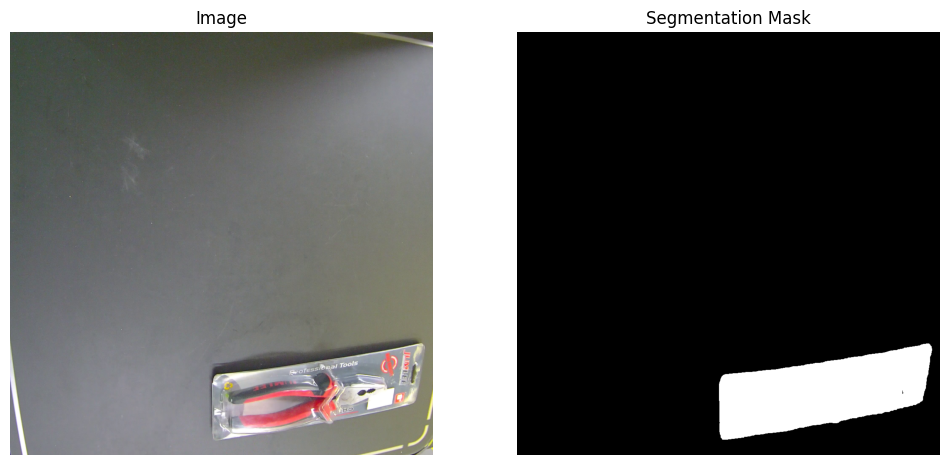

In [4]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# Assuming you've defined the CustomDataset class as before and instantiated it as `dataset`

def visualize_sample(dataset, idx):
    # Convert tensor to PIL Image for visualization
    to_pil = ToPILImage()
    
    # Get the image and mask from the dataset
    img, mask = dataset[idx]
    
    # Convert tensors back to PIL images (if using ToTensor transform)
    img = to_pil(img)
    mask = to_pil(mask)

    # Create a figure to display the images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Segmentation Mask')
    axes[1].axis('off')

    plt.show()

# Visualize the first image and its mask
visualize_sample(dataset, 5)

# If you want to visualize a second image, you can call it again with a different index
# visualize_sample(dataset, 1)


In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from pycocotools.coco import COCO
import os
import numpy as np
from torch import nn
from effdet.east.model import EfficientDetDoesEAST



In [6]:
# from effdet.segmentation.model import EfficientDetForSemanticSegmentation

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset and DataLoader setup
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

# Model setup
# model = EfficientDetForSemanticSegmentation(advprop=True, compound_coef=2)


In [7]:
class DiceLoss(nn.Module):
    
    def forward(self, y_true, scores, eps=1e-8):
        # compute the actual dice score
        dims = (1, 2)
        intersection = torch.sum(scores * y_true, dims)
        cardinality = torch.sum(scores + y_true, dims)

        dice_score = 2. * intersection / (cardinality + eps)
        return torch.mean(-dice_score + 1.)

In [8]:
class EffDetSegmentationPart(EfficientDetDoesEAST):
    
    def forward(self, x):
        _, _, height, width = x.shape
        feats = self.backbone(x)

        scores = self.scores(feats)
        scores = torch.sigmoid(scores)

        score_map = scores[:, 0] # take only the segmentation scores
        return score_map

In [9]:
model = EffDetSegmentationPart(advprop=True, compound_coef=4)



Loaded pretrained weights for efficientnet-b4


In [10]:
loss_fn = DiceLoss()

In [11]:

def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    model.backbone.freeze_bn() # freeze BN
    
    model.zero_grad()
    for imgs, targets in data_loader:
        imgs = imgs.to(device)
        targets = targets.to(device)

        # loss_dict = model(imgs, targets)  # Adjust according to your model's output
        scores = model(imgs.to(device))
        losses =  loss_fn(scores, targets)
        # losses = sum(loss for loss in loss_dict.values())
        if losses.isnan().item():
            model.zero_grad()
            break
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f"Epoch: {epoch}, Loss: {losses.item()}")

In [12]:

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.backbone.backbone_net.requires_grad_(False)
# Optimizer setup
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch)
    # save your model at the end of every epoch

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 5.79 GiB of which 89.38 MiB is free. Including non-PyTorch memory, this process has 5.48 GiB memory in use. Of the allocated memory 5.29 GiB is allocated by PyTorch, and 105.55 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)